In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from projections_starter_kit import *
from audio import *
torchaudio.set_audio_backend('soundfile')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Settings

For projections we need:
1. a model
1. a list of layers whose activations we will use
1. a data-loader

Define paths

In [82]:
path_proj = Path.cwd().parent                                        # The project directory

# datasets (audio files)
path_uw_dataset = path_proj/'datasets'/'data_uw_sounds'              # The downloaded dataset incl. audio files
path_model = path_proj/'models'/'audio_cnn_1'                        # models are saved here
path_features = path_proj/'audio_features'/'audio_cnn_1'             # The output folder - where the features are saved

In [4]:
path_model.exists(), path_uw_dataset.exists()

(True, True)

The DataLoader (Create a databunch from the audio clips in the dataset)

In [7]:
# Define some important constants - this needs to be moved to a separate included file
n_fft = 2048            # used for STFT: # samples used to generate fft
sample_rate = [44100, 8192, 1024]  # sample rates of the audio clips
hop_fac = [2, 4, 32]    # to determine hop_length
cdur = 5                # clip duration in seconds
n_mels = 224            # num of mel freq bands output
ref = 32768             # reference power for mel db calculation

In [8]:
sg_cfg= SpectrogramConfig(n_fft = n_fft, hop_length=int(n_fft/4), n_mels=n_mels, win_length= n_fft, 
                          top_db=80, f_min=0.0, f_max=22050.0, db_ref=ref)
cfg = AudioConfig(cache=True, duration=cdur*1000, sg_cfg=sg_cfg)

In [9]:
def get_label(f):
    return f.stem.split('-')[0]

tfms=None
db_audio = (AudioList.from_folder(path=path_uw_dataset, config=cfg)
            .split_by_rand_pct(0.0)
            .label_from_func(get_label)
            .transform(tfms=tfms)
            .databunch(bs=16, num_workers = 1))

The Model - load the model we have already trained

In [11]:
learn = load_learner(path=path_model, file='UW-99peakacc-stg1')
model = learn.model
# model = models.densenet161(pretrained=True).to(device)
# target_layers = [model.layer3[-2].conv2, model.layer4[-2].conv2, model.fc]

Define the target layer

In [76]:
target_layers = [model[1][4]]

## Create Projections

By default, we take spatially pooled activations from the specified layers, and concatenate accross layers. Then we do PCA with 20 components. The `plot_next` command loops through 2 dimensions at a time and plots them.

In [77]:
def flatten_col(output):  return output.view((output.shape[0], -1))
proj = Projector(model, target_layers, dl=db_audio.train_dl, collate_fn=flatten_col)

100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


In [79]:
import time

from fastai.vision import *
from projections_starter_kit import *
# from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


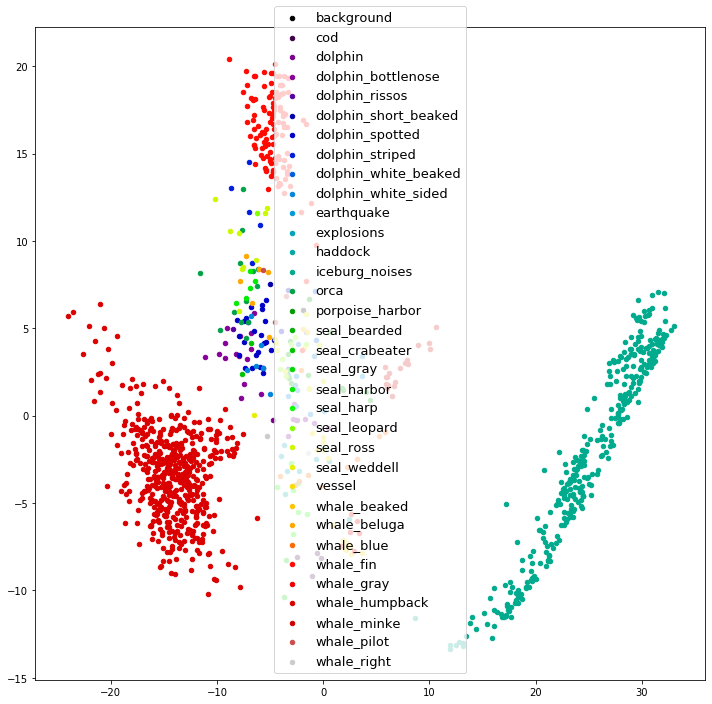

In [80]:
proj.plot_next(re_project=False, show_images=False)

In [100]:
def plot_and_save(result_path, name, proj):
    #plot and save figures for each 2D slice in the 10D matrix
    i = proj.counter
    savefig = str(result_path) + '{}_noimage_{}.png'.format(name, i)
    my_plot = proj.plot(axis=(i,i+1), re_project=False, 
                        xlabel='D{}'.format(i), ylabel='D{}'.format(i+1), 
                        title= name, figsize = (12,12), show_images=False, 
                        show_legend=False, savefig=savefig)
    
    proj.counter = (proj.counter + 2) % (proj.act_red.shape[-1] - 1)

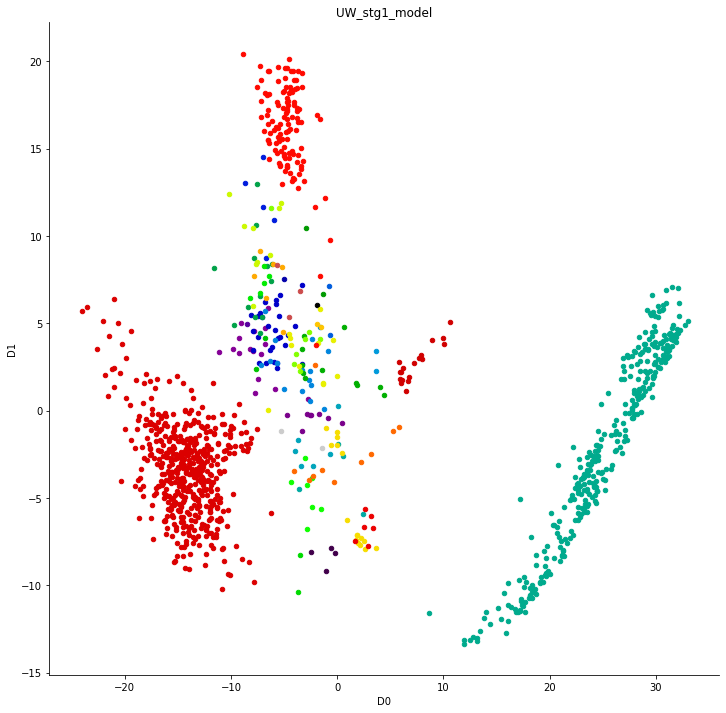

In [112]:
plot_and_save(path_features, 'UW_stg1_model', proj)